# Road Scene Semantic Segmentation

#### Dataloader (without augmentation)

In [39]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import numpy as np

class CityscapesDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None, label_transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.label_transform = label_transform
       
        self.image_paths = [os.path.join(image_folder, x) for x in os.listdir(image_folder) if x.endswith('.png')]
        self.label_paths = [os.path.join(label_folder, x) for x in os.listdir(label_folder) if x.endswith('gtFine_labelIds.png')]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label


# Image transformation with normalization
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing image
])

# Label transformation without normalization (just resizing and converting to tensor)
label_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0).long()), # Convert into from 1*H*W to H*W format and long type for Cross entropy

 # Convert label mask to tensor, no normalization
])




In [40]:
# Usage of dataset and dataloader
from torch.utils.data import DataLoader

dataset = CityscapesDataset(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/train_final',
    label_folder='D:/Citscapes dataset/Output/train_final',
    transform=image_transform,  # Apply the image transform
    label_transform=label_transform  # Apply the label transform
)




In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the dataloader and check shapes
for image, label in dataloader:
    print(image.shape)  
    print(label.shape)    
  
    break

torch.Size([4, 3, 512, 512])
torch.Size([4, 512, 512])


#### Visualization

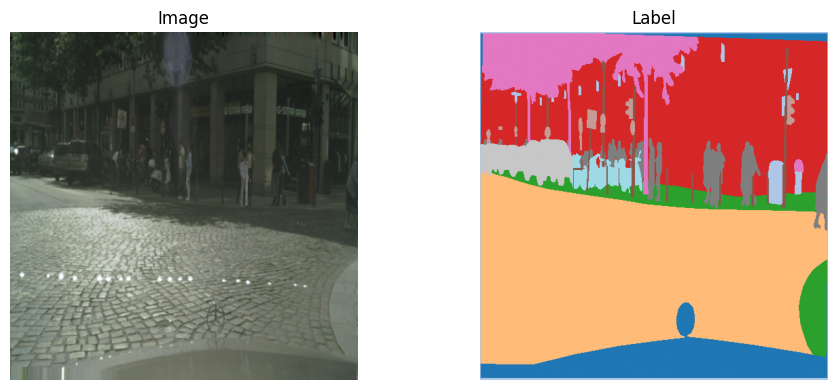

In [43]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

# Get one batch
images, masks = next(iter(dataloader))

# Visualize first 4 samples in batch
for i in range(1):
    img = images[i].cpu()
    mask = masks[i].cpu()

    # Denormalize the image
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)

    # Convert tensors to numpy
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # Plot
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='tab20')  # Color each class ID
    plt.title("Label")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


#### With Augmentation

In [44]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

class CityscapesDataset2(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
       
    
        self.image_paths = [os.path.join(image_folder, x) for x in os.listdir(image_folder) if x.endswith('.png')]
        self.label_paths = [os.path.join(label_folder, x) for x in os.listdir(label_folder) if x.endswith('gtFine_labelIds.png')]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = np.array(Image.open(img_path).convert('RGB'))  
        label = np.array(Image.open(label_path))

        # Apply the augmentations to both image and label
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label

# Define augmentations with Albumentations
transform = A.Compose([
    A.Resize(512, 512),  
    A.HorizontalFlip(p=0.5),  
    A.RandomBrightnessContrast(p=0.2),  
    A.RandomCrop(width=512, height=512, p=1.0),  
    ToTensorV2(), 
])

###IMPORTANT###
#TensorV2 automatically which transformations to apply to the image and  which to labels






In [46]:
from torch.utils.data import DataLoader

dataset = CityscapesDataset2(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/train_final',
    label_folder='D:/Citscapes dataset/Output/train_final',
    transform=transform 
)

dataloader2 = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the dataloader and check shapes
for image, label in dataloader:
    print(image.shape)  # Should print torch.Size([4, 3, 512, 512]) or similar
    print(label.shape)  # Should print torch.Size([4,  512, 512]) or similar  
    break


torch.Size([4, 3, 512, 512])
torch.Size([4, 512, 512])


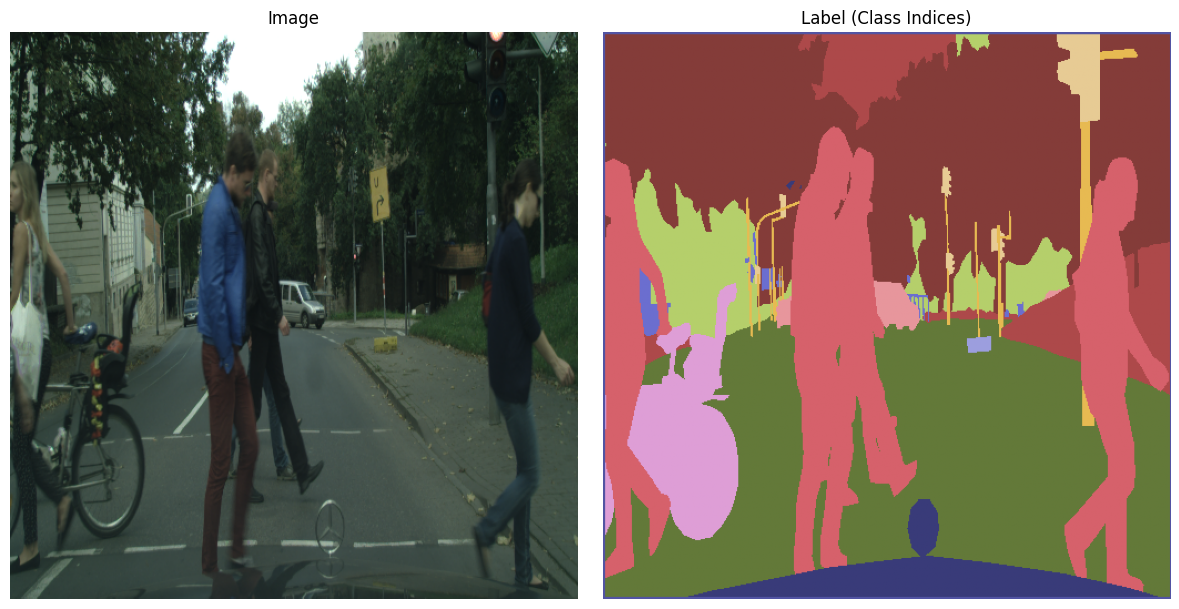

In [47]:
import matplotlib.pyplot as plt
import torch
import numpy as np


images, masks = next(iter(dataloader2))

for i in range(1):
    img = images[i].cpu() 
    mask = masks[i].cpu()  

  
    img_np = img.permute(1, 2, 0).numpy() 
    mask_np = mask.numpy()  

    # Plot the image and mask side by side
    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    # Plot the mask (label)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='tab20b')  # Use 'tab20b' for color coding of class IDs
    plt.title("Label (Class Indices)")
    plt.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()
